In [10]:
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.metrics import classification_report, confusion_matrix
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [11]:
Class = os.listdir("caltech-101")
Class

['accordion',
 'airplanes',
 'anchor',
 'ant',
 'BACKGROUND_Google',
 'barrel',
 'bass',
 'beaver',
 'binocular',
 'bonsai',
 'brain',
 'brontosaurus',
 'buddha',
 'butterfly',
 'camera',
 'cannon',
 'car_side',
 'ceiling_fan',
 'cellphone',
 'chair',
 'chandelier',
 'cougar_body',
 'cougar_face',
 'crab',
 'crayfish',
 'crocodile',
 'crocodile_head',
 'cup',
 'dalmatian',
 'dollar_bill',
 'dolphin',
 'dragonfly',
 'electric_guitar',
 'elephant',
 'emu',
 'euphonium',
 'ewer',
 'Faces',
 'Faces_easy',
 'ferry',
 'flamingo',
 'flamingo_head',
 'garfield',
 'gerenuk',
 'gramophone',
 'grand_piano',
 'hawksbill',
 'headphone',
 'hedgehog',
 'helicopter',
 'ibis',
 'inline_skate',
 'joshua_tree',
 'kangaroo',
 'ketch',
 'lamp',
 'laptop',
 'Leopards',
 'llama',
 'lobster',
 'lotus',
 'mandolin',
 'mayfly',
 'menorah',
 'metronome',
 'minaret',
 'Motorbikes',
 'nautilus',
 'octopus',
 'okapi',
 'pagoda',
 'panda',
 'pigeon',
 'pizza',
 'platypus',
 'pyramid',
 'revolver',
 'rhino',
 'rooste

In [12]:
sdir=r'caltech-101'
filepaths = []
labels=[] 
classlist=sorted(os.listdir(sdir) )  
for klass in classlist:
    classpath=os.path.join(sdir, klass)
    flist=os.listdir(classpath)        
    for f in flist:
        fpath=os.path.join(classpath,f)
        filepaths.append(fpath)
        labels.append(klass)
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')        
df=pd.concat([Fseries, Lseries], axis=1)
Fseries.head()

0    caltech-101\BACKGROUND_Google\image_0001.jpg
1    caltech-101\BACKGROUND_Google\image_0002.jpg
2    caltech-101\BACKGROUND_Google\image_0003.jpg
3    caltech-101\BACKGROUND_Google\image_0004.jpg
4    caltech-101\BACKGROUND_Google\image_0005.jpg
Name: filepaths, dtype: object

In [13]:
IMAGE_SIZE = 224
CHANNELS = 3

train_datagen = ImageDataGenerator(
        rescale = 1./255,
        horizontal_flip = True,
        rotation_range = 10
)
train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = 32,
    class_mode = 'categorical',
)

Found 6353 images belonging to 102 classes.


In [14]:
validation_datagen = ImageDataGenerator(
        rescale = 1./255,
        horizontal_flip = True,
        rotation_range = 10
)
validation_generator = validation_datagen.flow_from_directory(
    'dataset/val',
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = 32,
    class_mode = 'categorical',
)

Found 866 images belonging to 102 classes.


In [15]:
test_datagen = ImageDataGenerator(
        rescale = 1./255,
        horizontal_flip = True,
        rotation_range = 10
)
test_generator = test_datagen.flow_from_directory(
    'dataset/test',
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = 32,
    class_mode = 'categorical',
)

Found 1925 images belonging to 102 classes.


In [16]:
from tensorflow.keras.applications.vgg16 import VGG16

In [17]:
input_shape = (IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3
pre_trained_model = VGG16(
    input_shape = input_shape,
    include_top = False,
    weights = "imagenet"
)

for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:

model = tf.keras.models.Sequential([
    pre_trained_model,
    
    Flatten(),    
    Dense(256,activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(102, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 102)               26214     
                                                        

In [19]:
model.compile(
            optimizer="adam",
            loss='categorical_crossentropy',
            metrics = ['acc']
)

In [20]:
history = model.fit_generator(
            train_generator,
            validation_data=test_generator,
            epochs=8
)

Epoch 1/8
199/199 [==============================] - 2325s 12s/step - loss: 1.8362 - acc: 0.6093 - val_loss: 1.1871 - val_acc: 0.7299
Epoch 2/8
199/199 [==============================] - 1729s 9s/step - loss: 0.7852 - acc: 0.8303 - val_loss: 0.7727 - val_acc: 0.8166
Epoch 3/8
199/199 [==============================] - 1713s 9s/step - loss: 0.4827 - acc: 0.8972 - val_loss: 0.6668 - val_acc: 0.8353
Epoch 4/8
199/199 [==============================] - 1726s 9s/step - loss: 0.3376 - acc: 0.9298 - val_loss: 0.6897 - val_acc: 0.8249
Epoch 5/8
199/199 [==============================] - 1670s 8s/step - loss: 0.2722 - acc: 0.9405 - val_loss: 0.6425 - val_acc: 0.8312
Epoch 6/8
199/199 [==============================] - 1703s 9s/step - loss: 0.2154 - acc: 0.9520 - val_loss: 0.5671 - val_acc: 0.8462
Epoch 7/8
199/199 [==============================] - 1651s 8s/step - loss: 0.1538 - acc: 0.9671 - val_loss: 0.6017 - val_acc: 0.8473
Epoch 8/8
199/199 [==============================] - 2643s 13s/step 

In [21]:
history.history

{'loss': [1.8361881971359253,
  0.7851518988609314,
  0.48268789052963257,
  0.3375663161277771,
  0.2721620500087738,
  0.21539294719696045,
  0.15376527607440948,
  0.1227182075381279],
 'acc': [0.6093184351921082,
  0.8303163647651672,
  0.8972139358520508,
  0.9297969341278076,
  0.9405005574226379,
  0.9519912004470825,
  0.9671021699905396,
  0.9745002388954163],
 'val_loss': [1.1871200799942017,
  0.77273029088974,
  0.6667705774307251,
  0.6897390484809875,
  0.6424952149391174,
  0.5670770406723022,
  0.6017237305641174,
  0.5828700661659241],
 'val_acc': [0.7298701405525208,
  0.8166233897209167,
  0.8353247046470642,
  0.8249350786209106,
  0.8311688303947449,
  0.8462337851524353,
  0.8472727537155151,
  0.8462337851524353]}

Text(0.5, 1.0, 'Training and validation loss')

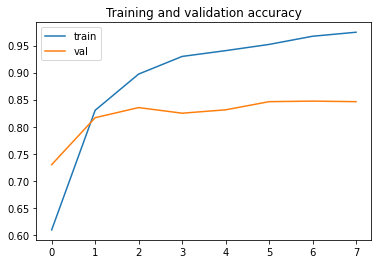

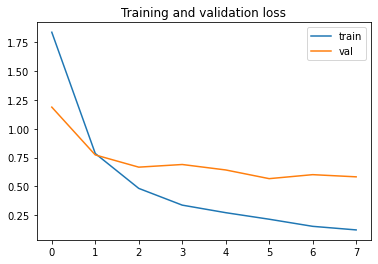

In [22]:
import matplotlib.pyplot as plt

acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc))


# Plot training and validation accuracy per epoch
plt.plot(epochs,acc)
plt.plot(epochs,val_acc)
plt.title('Training and validation accuracy')
plt.legend(['train','val'])
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs,loss)
plt.plot(epochs,val_loss)
plt.legend(['train','val'])
plt.title('Training and validation loss')

In [23]:
model.save("caltech.h5")